# Toy 8: Convex function

Represent engineering-like problems with trade-offs


In [1]:
import torch
import os
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_01")
os.makedirs(save_dir, exist_ok=True)

f_param = "toy_8_20251121_1814"
save_heading = os.path.join(save_dir, f_param + "_analysis")
d_opt = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_param + ".xlsx"), sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

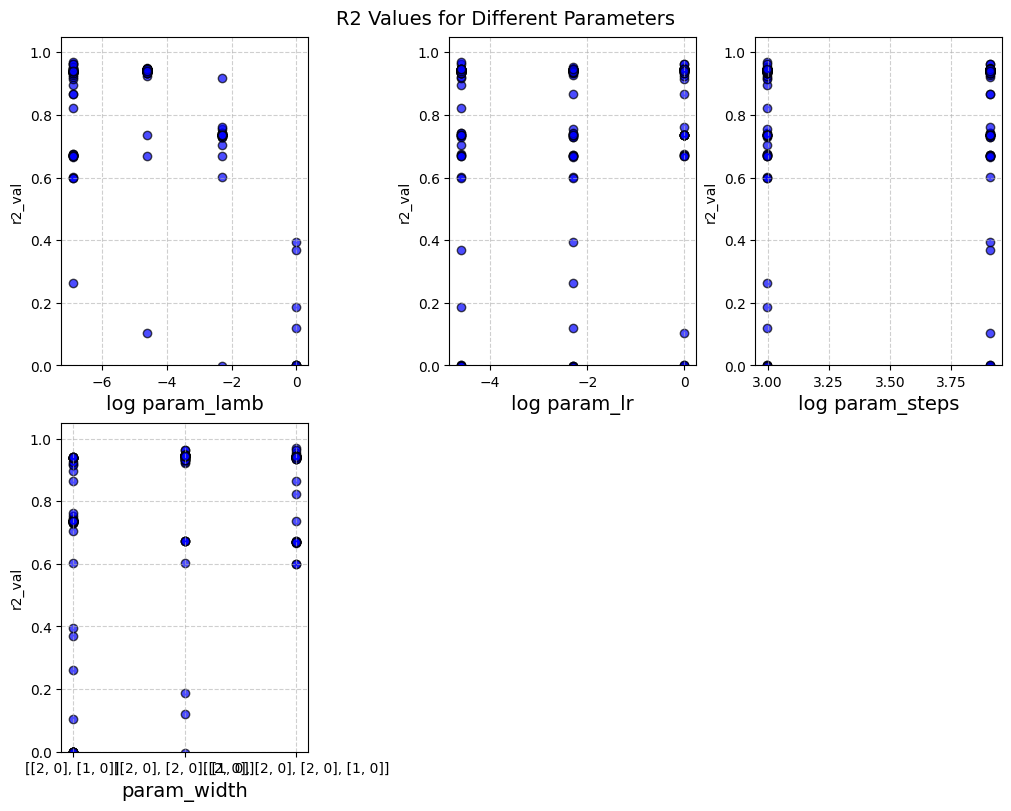

In [2]:
f_tuning = f_param
df = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_tuning + ".xlsx"), sheet_name='results')

param_cols = [col for col in df.columns if 'param' in col and df[col].nunique() > 1]
num_params = len(param_cols)
cols = 3
rows = int(np.ceil(num_params / cols))

fig, axs = plt.subplots(rows, cols, figsize=(10, 4*rows), constrained_layout=True)
axs = np.atleast_1d(axs).flatten()

for i, param_name in enumerate(param_cols):
    ax = axs[i]

    if pd.api.types.is_numeric_dtype(df[param_name]):
        ax.scatter(np.log(df[param_name]), df['r2_val'], alpha=0.7, c='blue', edgecolors='k')
        ax.set_xlabel("log " + param_name, fontsize=14)
    else:
        ax.scatter(df[param_name], df['r2_val'], alpha=0.7, c='blue', edgecolors='k')
        ax.set_xlabel(param_name, fontsize=14)
    ax.set_ylim([0, 1.05])
    ax.set_ylabel('r2_val')
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(num_params, len(axs)):
    axs[i].axis('off')

plt.suptitle("R2 Values for Different Parameters", fontsize=14)
plt.show()

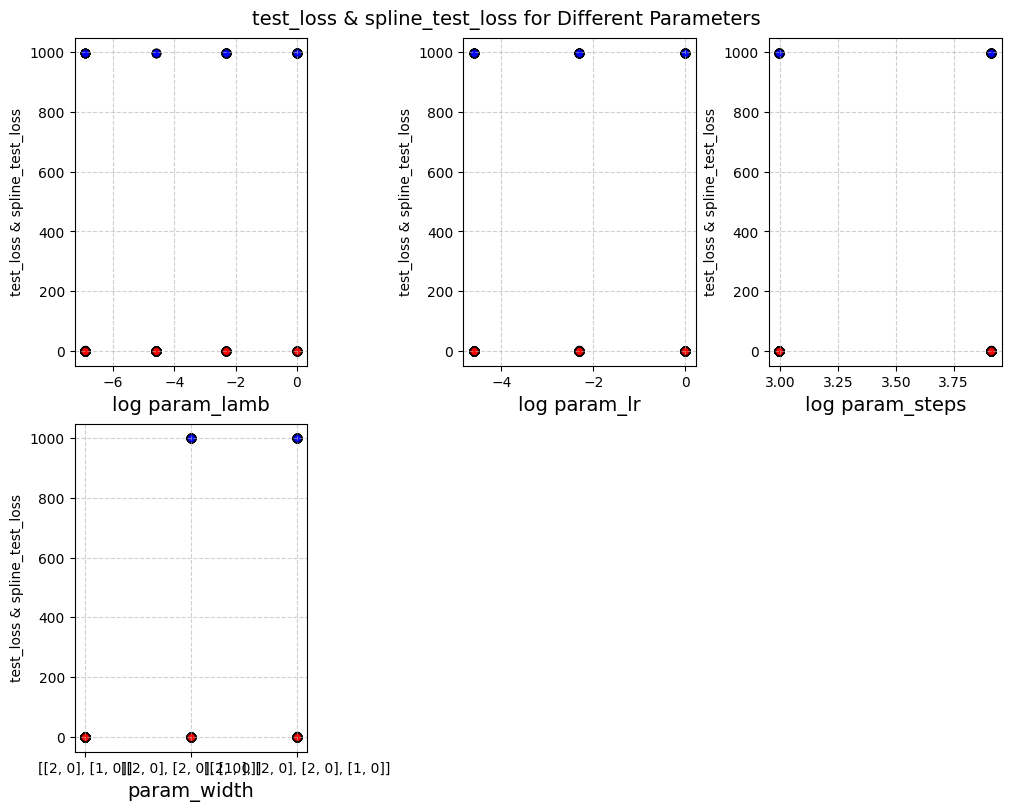

In [3]:
fig, axs = plt.subplots(rows, cols, figsize=(10, 4*rows), constrained_layout=True)
axs = np.atleast_1d(axs).flatten()
metric = 'test_loss'
metric2 = 'spline_test_loss'

for i, param_name in enumerate(param_cols):
    ax = axs[i]

    if pd.api.types.is_numeric_dtype(df[param_name]):
        ax.scatter(np.log(df[param_name]), df[metric], alpha=0.7, c='blue', edgecolors='k')
        ax.scatter(np.log(df[param_name]), df[metric2], alpha=0.7, c='red', edgecolors='k')
        ax.set_xlabel("log " + param_name, fontsize=14)
    else:
        ax.scatter(df[param_name], df[metric], alpha=0.7, c='blue', edgecolors='k')
        ax.scatter(df[param_name], df[metric2], alpha=0.7, c='red', edgecolors='k')
        ax.set_xlabel(param_name, fontsize=14)
    # ax.set_ylim([0, 1.05])
    ax.set_ylabel(metric + ' & ' + metric2)
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(num_params, len(axs)):
    axs[i].axis('off')

plt.suptitle(f"{metric} & {metric2} for Different Parameters", fontsize=14)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

name_X = ["x1", "x2"]
name_y = "y"

x1_grid = np.linspace(-1, 1, 40)
x2_grid = np.linspace(-1, 1, 40)

x1, x2 = np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
y = x1 ** 2 / (x2 + 1.02) / 10 + np.exp(2 * x2)
y = y.flatten().reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)
dataset = {
    'train_input': torch.tensor(X_train_norm, dtype=torch.float32, device=device),
    'train_label': torch.tensor(y_train_norm, dtype=torch.float32, device=device),
    'test_input': torch.tensor(X_test_norm, dtype=torch.float32, device=device),
    'test_label': torch.tensor(y_test_norm, dtype=torch.float32, device=device),
    'val_input': torch.tensor(X_val_norm, dtype=torch.float32, device=device),
    'val_label': torch.tensor(y_val_norm, dtype=torch.float32, device=device),
}

전체 데이터셋 크기: 1600
훈련셋 크기: 1024 (64.0%)
검증셋 크기: 256 (16.0%)
테스트셋 크기: 320 (20.0%)


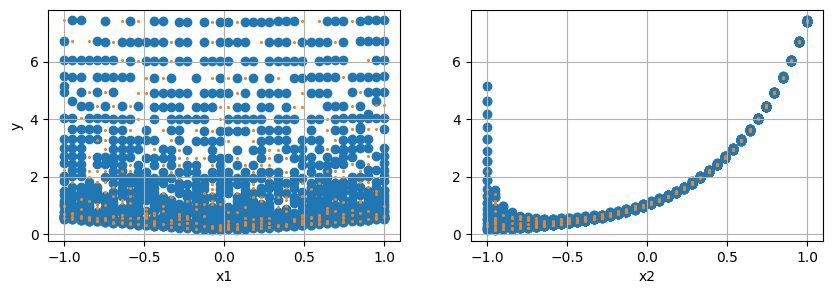

In [5]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()

| train_loss: 6.21e-02 | test_loss: 4.58e-02 | reg: 1.87e+00 | : 100%|█| 50/50 [00:11<00:00,  4.49it
| train_loss: 6.18e-02 | test_loss: 4.52e-02 | reg: 1.87e+00 | : 100%|█| 50/50 [00:06<00:00,  7.78it


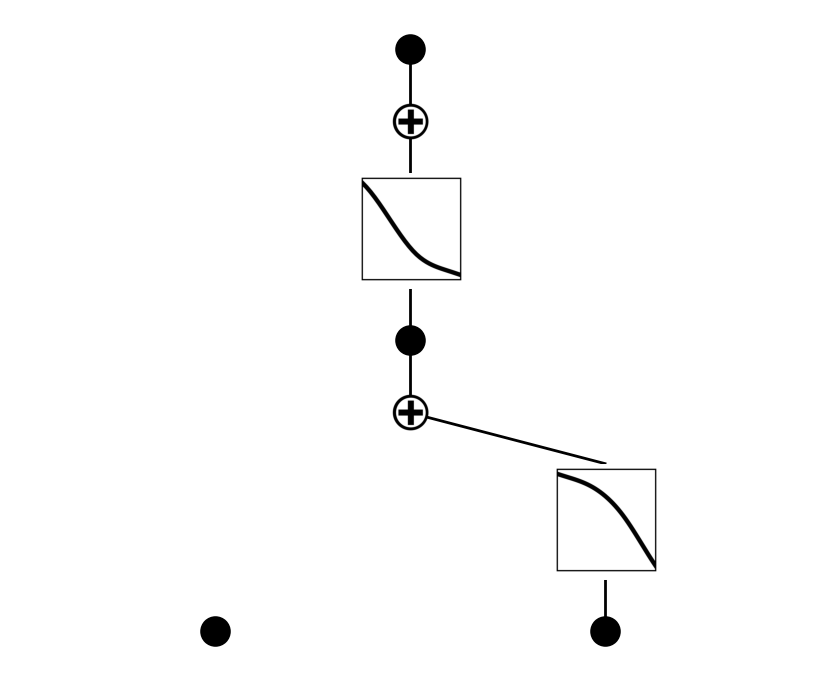

| train_loss: 5.85e-02 | test_loss: 3.84e-02 | reg: 1.87e+00 | : 100%|█| 50/50 [00:06<00:00,  8.00it


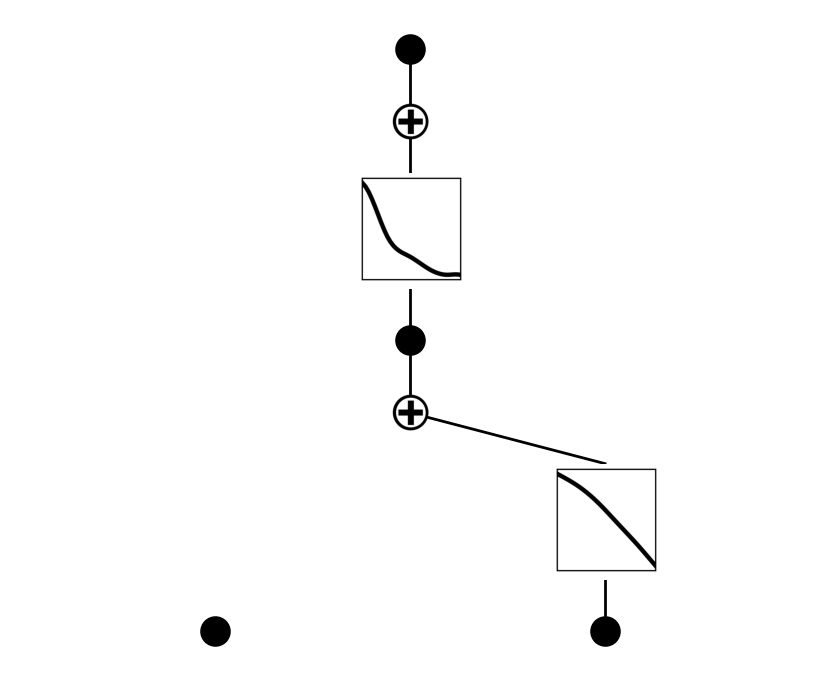

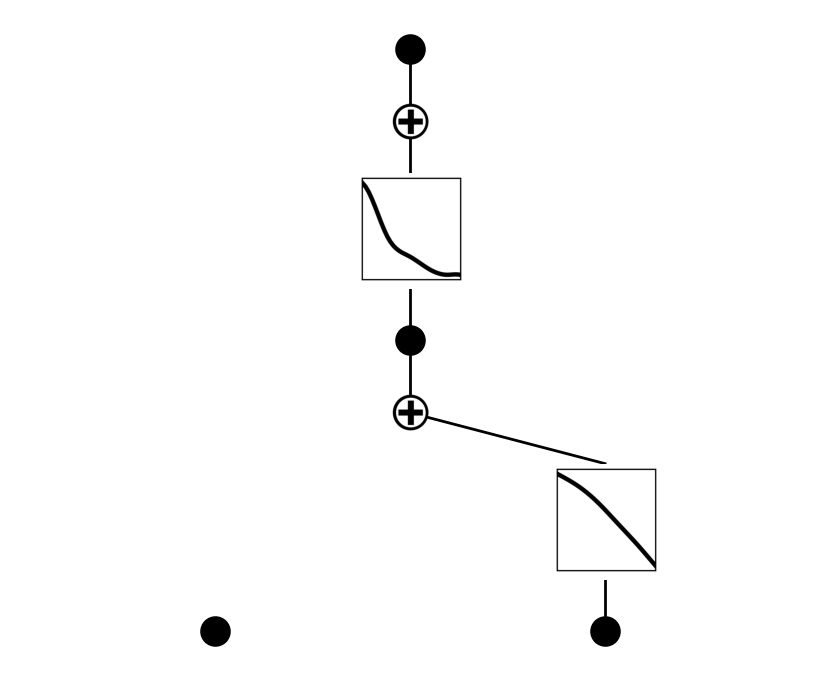

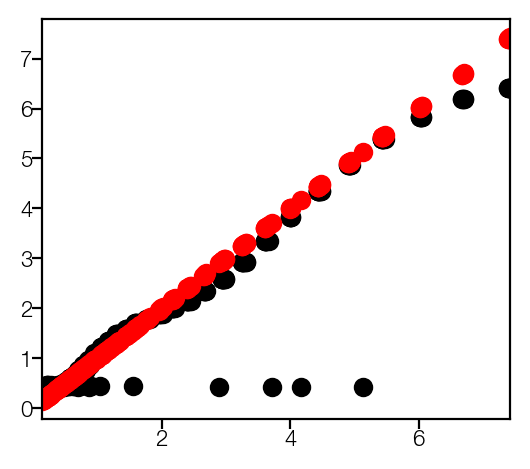

TrialResult(params={'lamb': 0.01, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5, 'lamb_entropy': 0.1, 'lr': 0.1, 'prune': True, 'pruning_th': 0.05, 'steps': 50, 'stop_grid_update_step': 20, 'symbolic': False, 'width': [[2, 0], [2, 0], [1, 0]]}, val_loss=0.22953581809997559, train_loss=0.20435810089111328, test_loss=0.17527252435684204, r2_train=0.9521924373294072, r2_val=0.9254310839123621, r2_test=0.9775985174210468, seed=0, device='cpu', spline_train_loss=0.057985782623291016, spline_test_loss=0.03932245448231697)


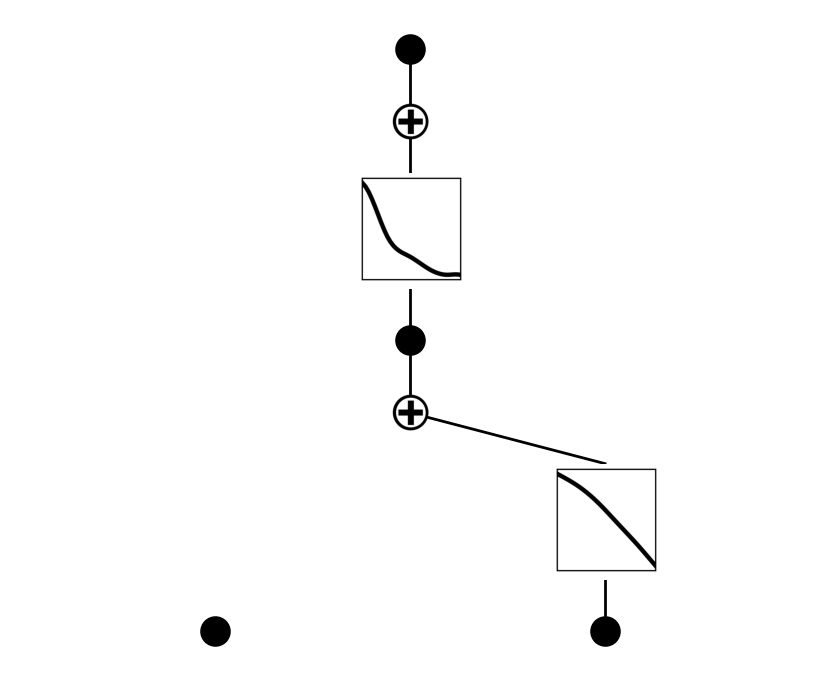

In [6]:
from kan.experiments.multkan_hparam_sweep import evaluate_params
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}
params['symbolic'] = False

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

In [7]:
from kan.utils import ex_round
# model.auto_symbolic()
# model.fit(dataset, **fit_kwargs)
# model.plot()
# plt.show()
# ex_round(model.symbolic_formula()[0][0], 4)

{'train': 0.952192439471073, 'test': 0.9775985186238613}


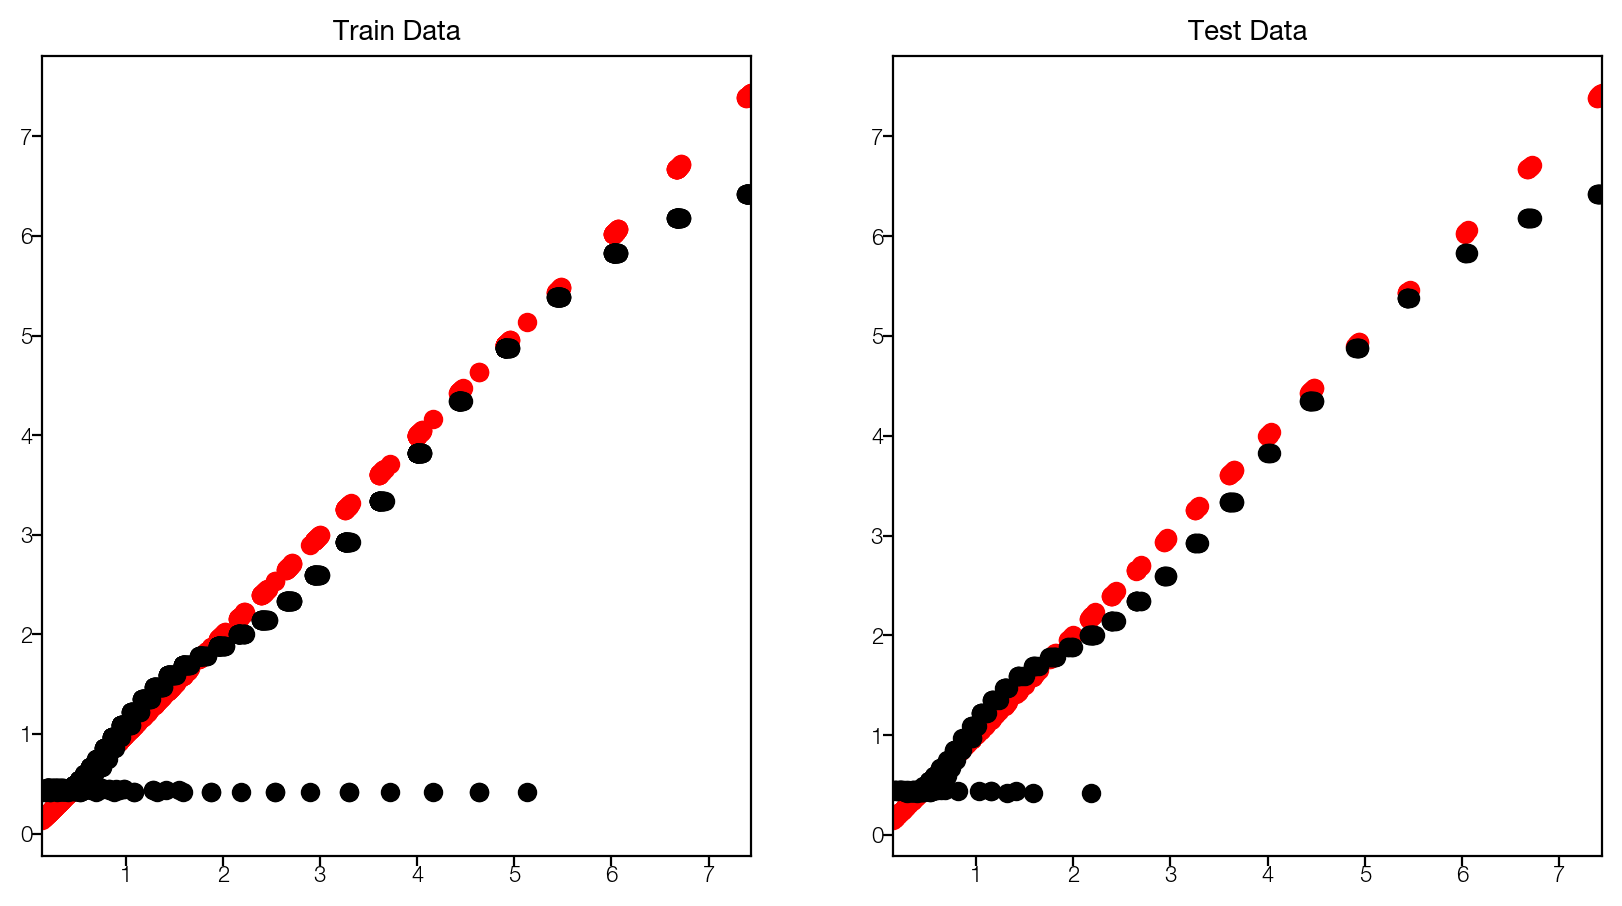

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)
# y_train = dataset['train_label']
# y_test = dataset['test_label']

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='r')
ax_train.scatter(y_train, y_pred_train, color='k')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='r')
ax_test.scatter(y_test, y_pred_test, color='k')
ax_test.set_title("Test Data")

plt.show()
plt.show()

Text(0, 0.5, 'Attribution score')

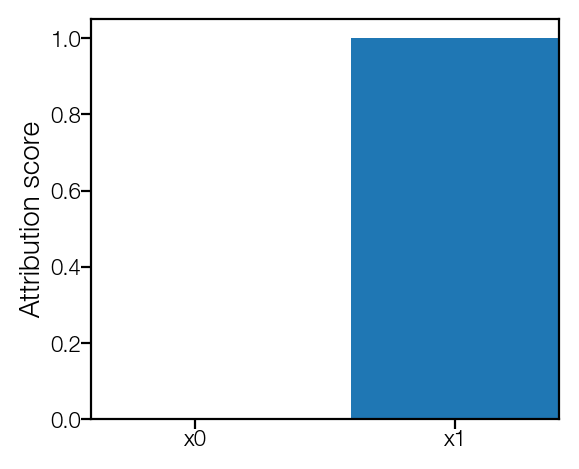

In [9]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

Layer 0 : in 0 -- out 0
Slope: [0.006146329455077648, 0.0009862147271633148, 0.013713442720472813, -0.004172185435891151, 0.004007080569863319, 0.005129145458340645, -0.00683559849858284]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0]
Inflection point: None
Layer 0 : in 1 -- out 0
Slope: [-0.0002669026143848896, 0.019014570396393538, -0.003941657021641731, -0.025833547115325928, -0.0024713650345802307, -0.011515466496348381, 0.004747791215777397]
[-1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0]
Inflection point: 0.0


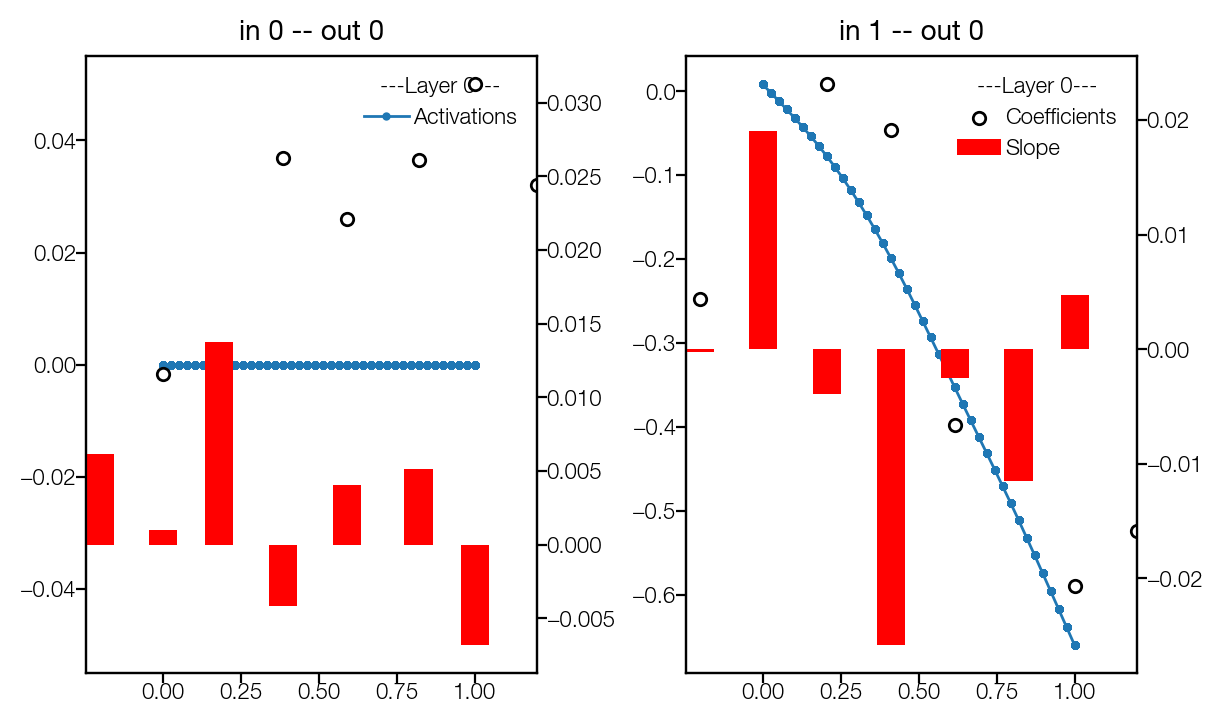

In [10]:
def find_index_sign_revert(data_list, epsilon=5e-3):
    """
    Finds the first index where the sign changes and persists for
    more than one element.

    Values with absolute magnitude smaller than epsilon are treated as having the same sign as the previous element, effectively ignoring small fluctuations around zero.

    Args:
        data_list (list): A list of numbers.
        epsilon (float): The threshold below which a value is considered to have "no sign change" relative to the previous value.

    Returns:
        int or None: The first index of a persistent sign change,
                     or None if no such change is found.
    """
    if len(data_list) < 3:
        return None

    effective_signs = [np.sign(data_list[0])]

    for i in range(1, len(data_list)):
        val = data_list[i]
        prev_sign = effective_signs[-1]

        if abs(val) < epsilon:
            effective_signs.append(prev_sign)
        else:
            effective_signs.append(np.sign(val))
    print(effective_signs)

    # Now search for the persistent sign change using these cleaned signs
    for i in range(1, len(effective_signs) - 1):
        if effective_signs[i] != effective_signs[i-1]:
            if effective_signs[i+1] == effective_signs[i]:
                return i

    return None

depth = len(model.act_fun)
layers_to_plot = [0]
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            print(f'Layer {l} : in {i} -- out {j}')
            print(f'Slope: {slope}')

            idx_revert = find_index_sign_revert(slope)
            if idx_revert is None:
                inflection_val = None
            else:
                inflection_val = act.grid[i, spline_radius + idx_revert]
            inflection_points_per_layer.append(inflection_val)

            print(f'Inflection point: {inflection_val}')
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()

[tensor(27), tensor(997)]


C:\Users\user\AppData\Local\Temp\ipykernel_36436\1007082116.py:20: RuntimeWarning: invalid value encountered in divide
  score_norm = score_masked / x_std


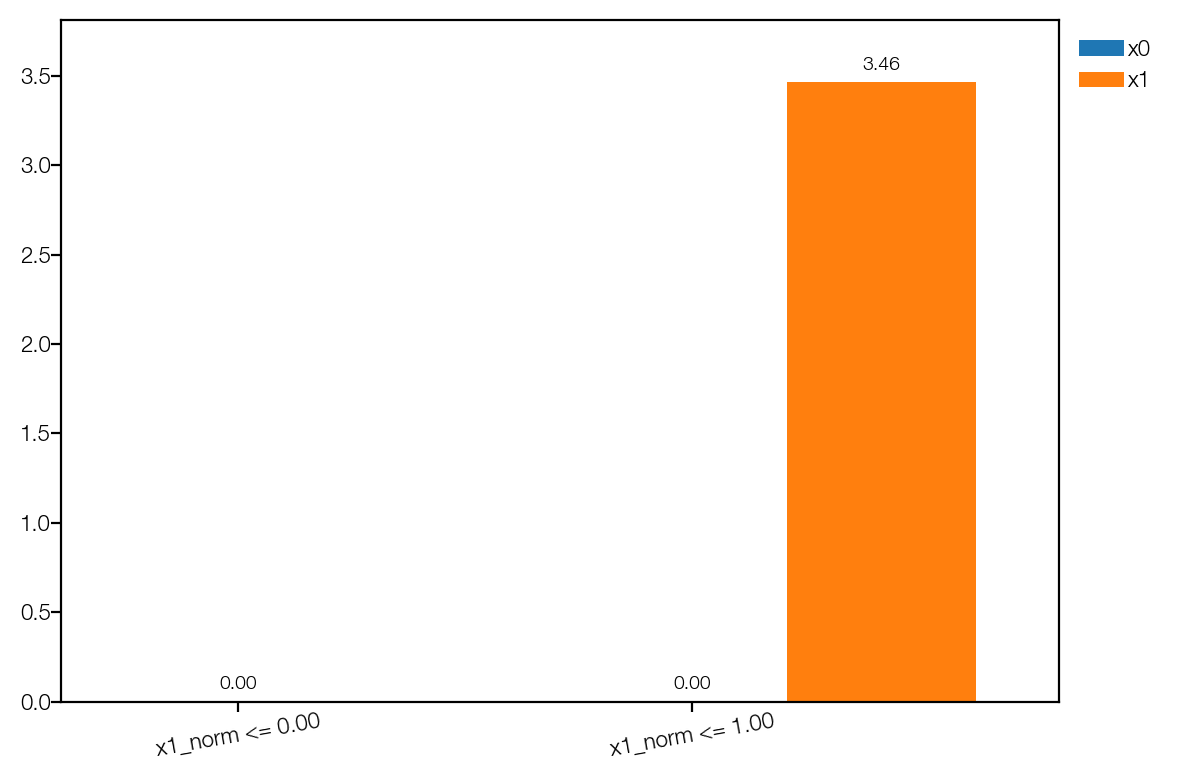

In [11]:
mask_idx = 1
mask_interval = [-1, inflection_points[0][mask_idx], 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx}_norm <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()